## Task : supervised-multi-class classfication
<br>
**object : predict poverty on a household level** <br>

#### Target values
<br>
1 = extreme poverty 
2 = moderate poverty 
3 = vulnerable households 
4 = non vulnerable households
<br>

#### Metric
- F1 score = 2*(precision*recall)/(precision+recall) (이진분류)
- Macro F1 = (F1_class_1+F1_class_2+F1_class_3+F1_class_4)/4 (다중분류)
그러나 imbalance data set에 가중평균 사용하면 안됨

```
from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro`)
```

#### data project road map
1. 문제의 이해
2. EDA - 이상치, 추세, 상관관계, 패턴
3. Feature engineering
4. base line models
5. 복잡한 모델들 
6. 최적화
7. 문제에서 모델 예측 조사
8. 결론 도출

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [2]:
pd.options.display.max_columns = 150

train = pd.read_csv('../../DATA/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('../../DATA/costa-rican-household-poverty-prediction/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


130개의 정수형, 8개의 실수형, 5개의 문자형

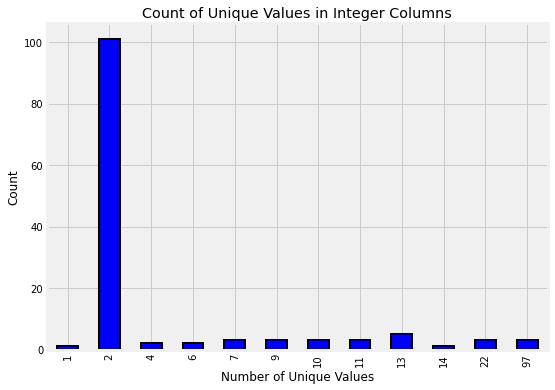

In [4]:
# 정수형

train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

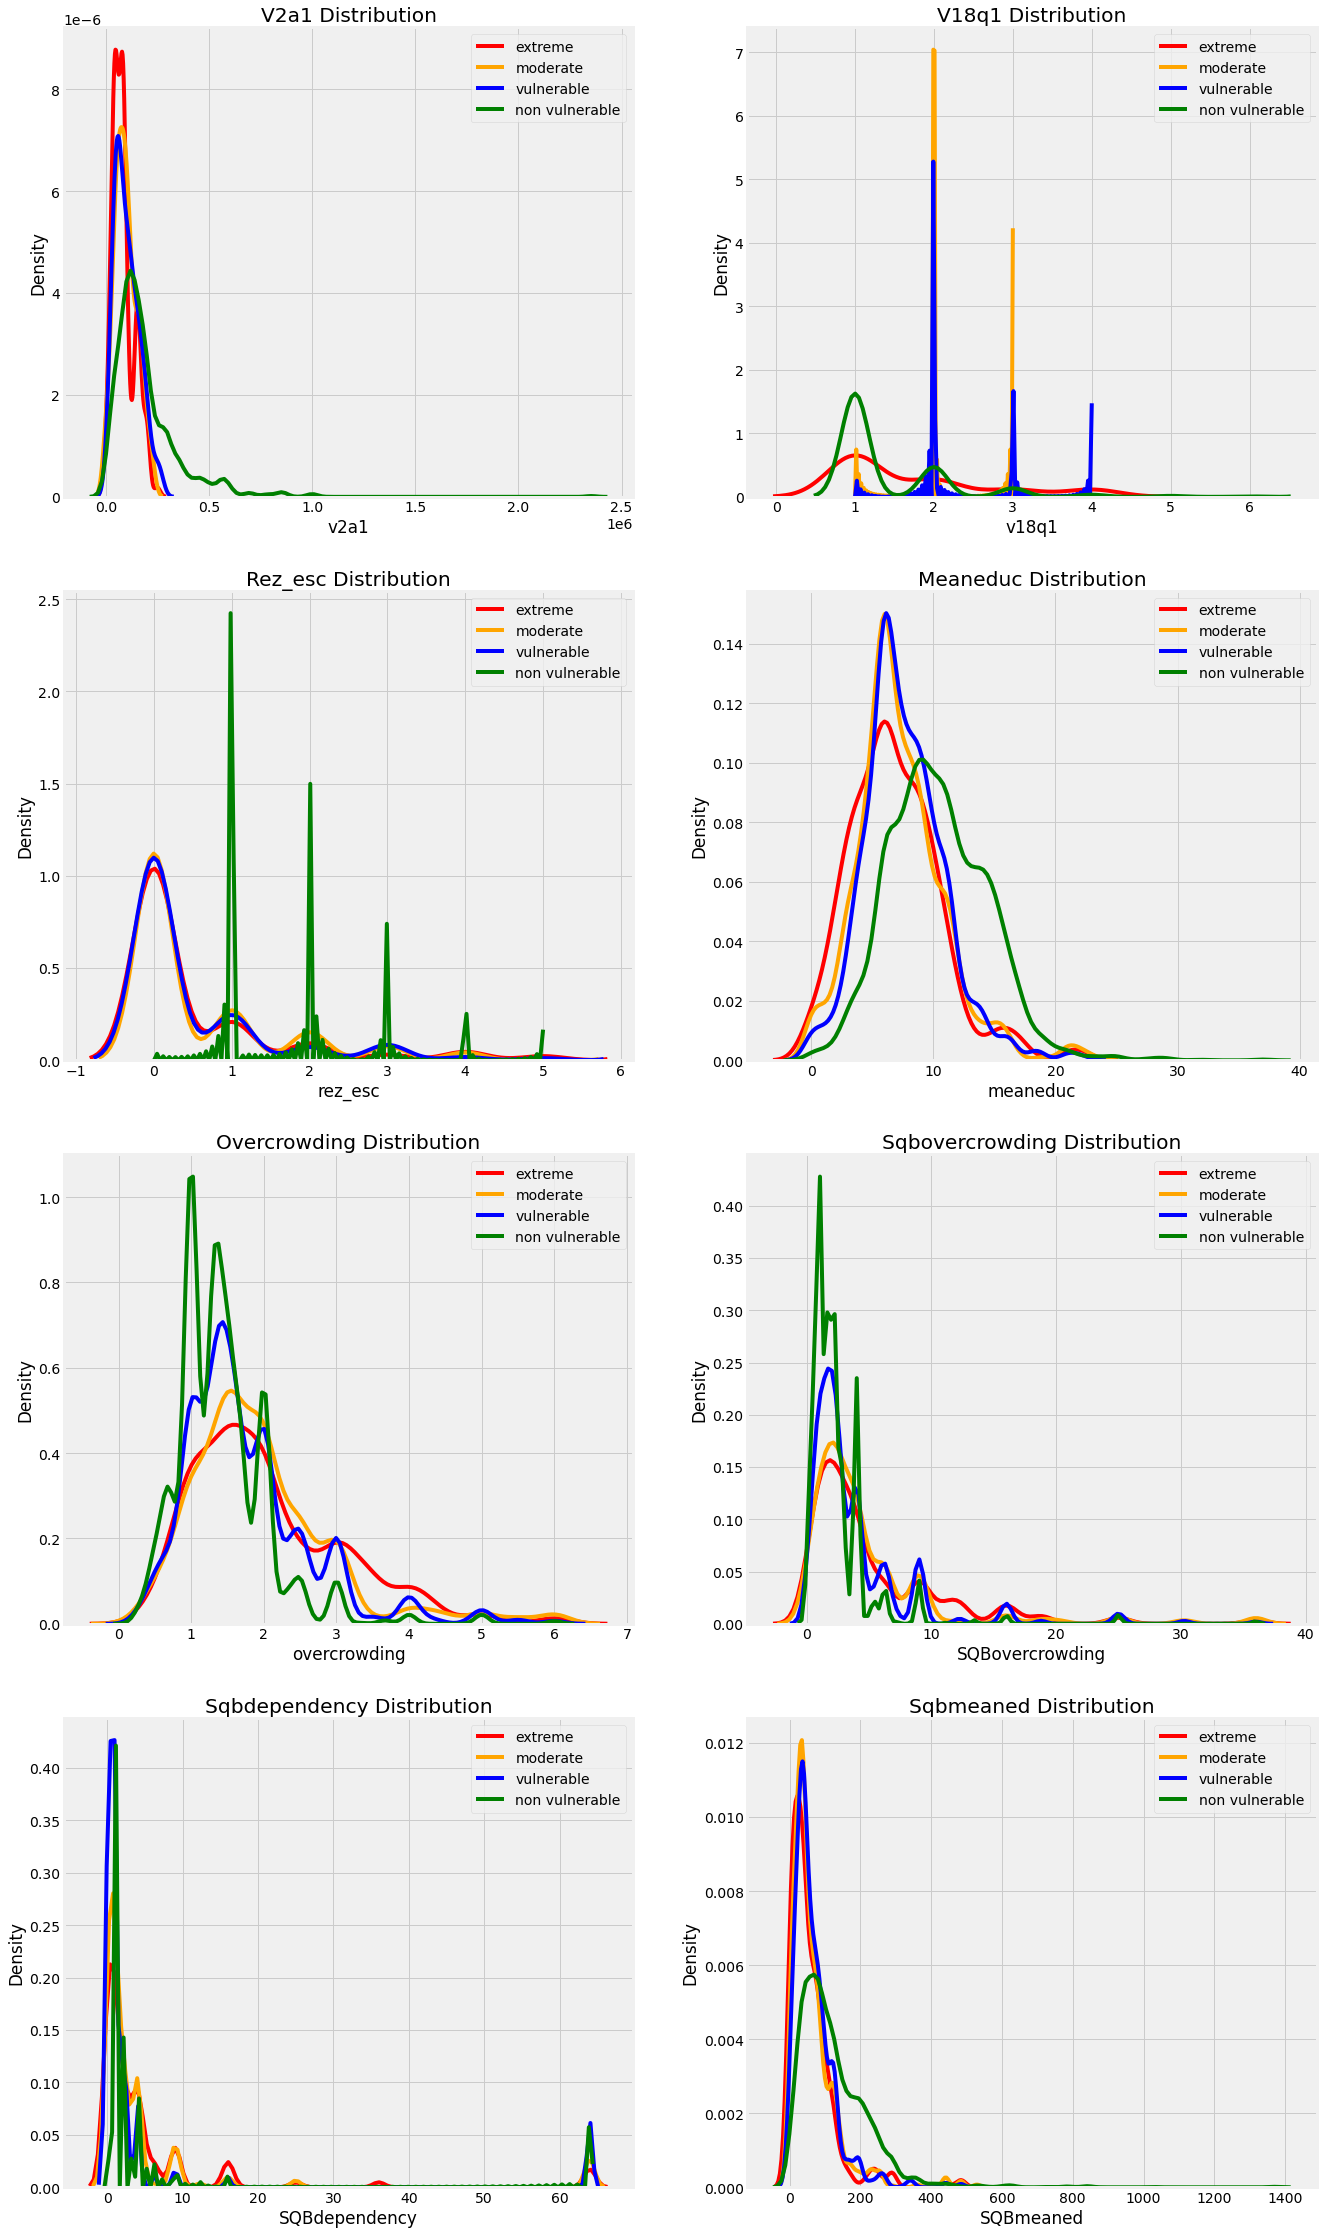

In [5]:
# 실수형 

from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# 실수형 반복
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # the poverty levels 반복
    for poverty_level, color in colors.items():
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [6]:
# 문자열
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [7]:
mapping = {"yes": 1, "no": 0}

for df in [train, test]:
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


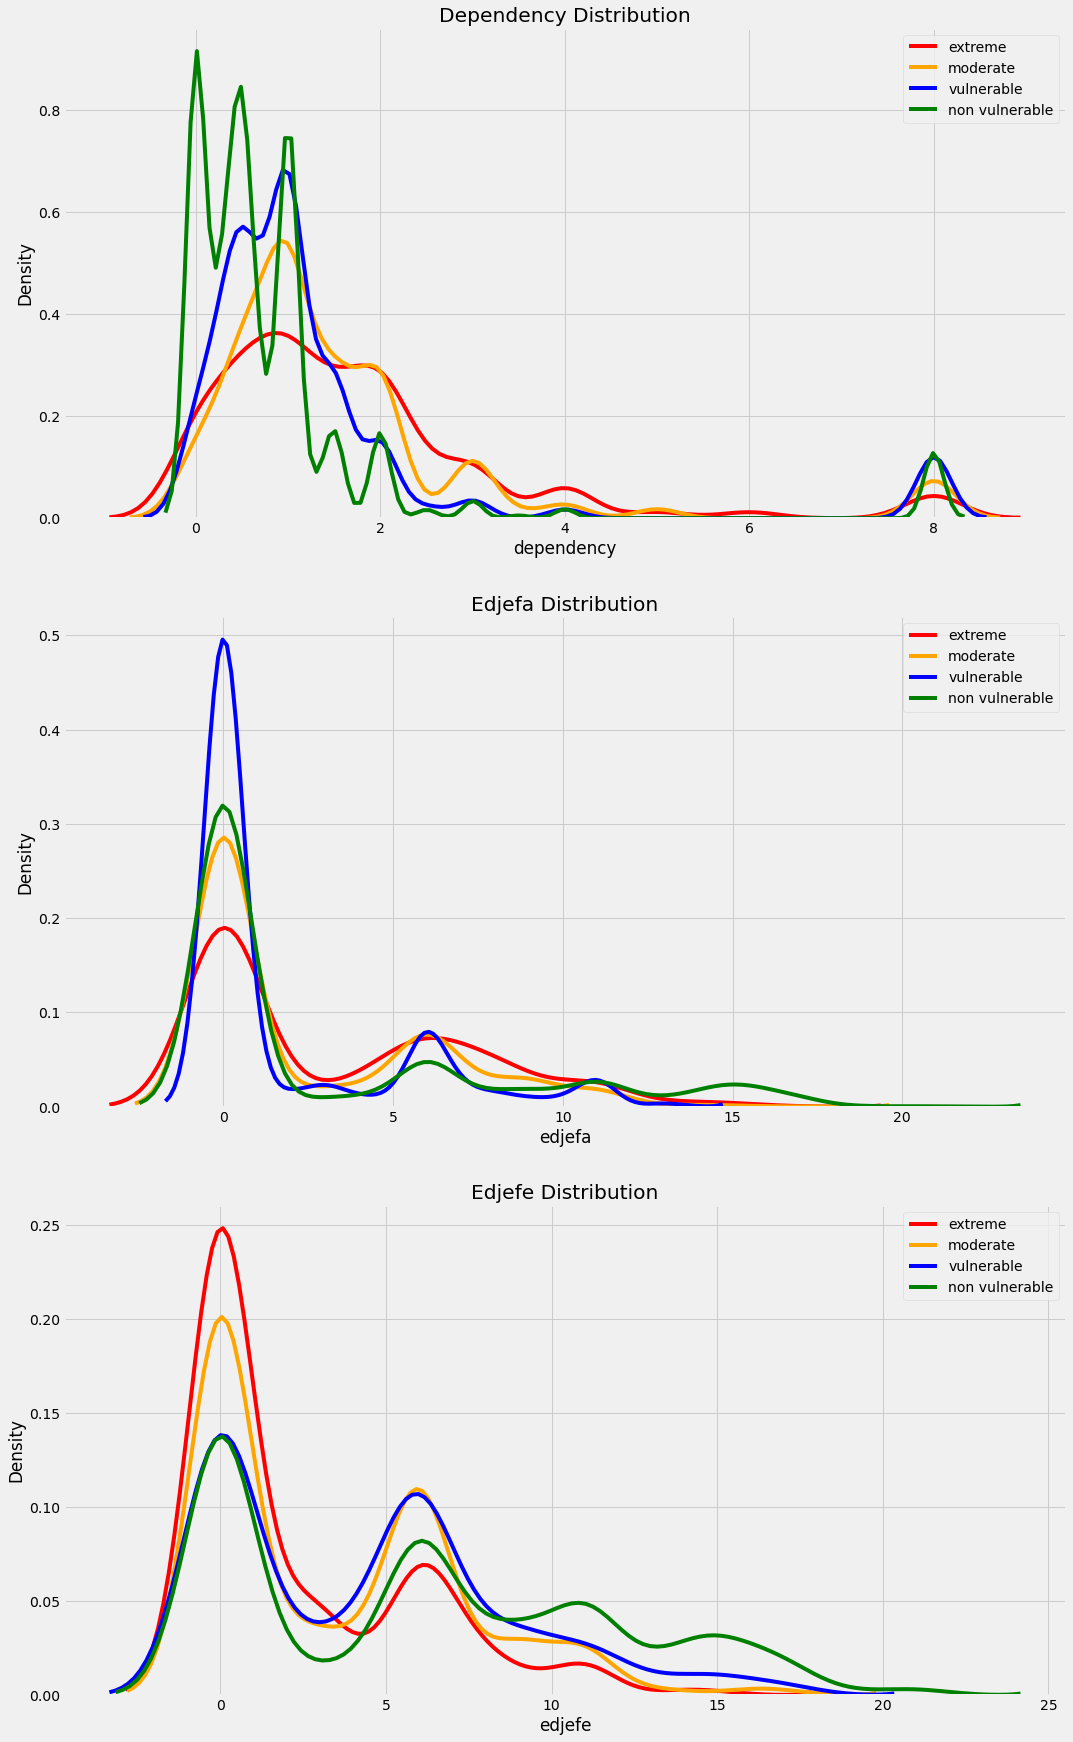

In [9]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [10]:
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

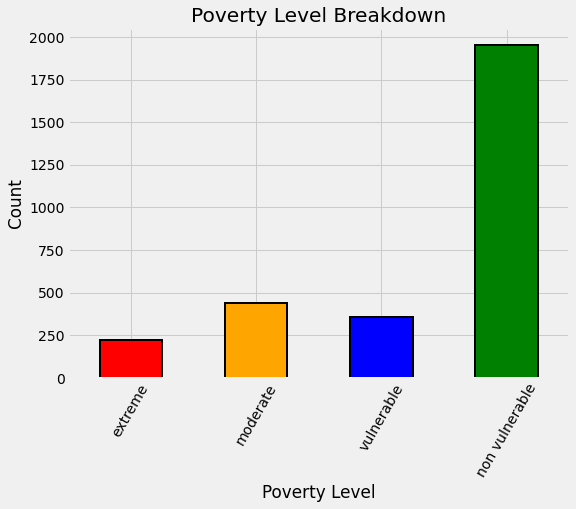

In [11]:
# 라벨 분포 탐색
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

#### weight F1을 써야하는 이유는 imbalnce class 문제때문이다. class가 적으면 예측에 실패할 수 있다. 

In [12]:
# 잘못된 Label 정리
# Identify Error : house holde기준으로 group data하고 Target이 하나인지 찾는다


In [13]:
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [14]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


In [16]:
# Find households without a head
households_leader = train.groupby('idhogar')['parentesco1'].sum()
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [17]:
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


In [18]:
# 오류 수정

for household in not_equal.index:
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


In [19]:
# 결측치 
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [20]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

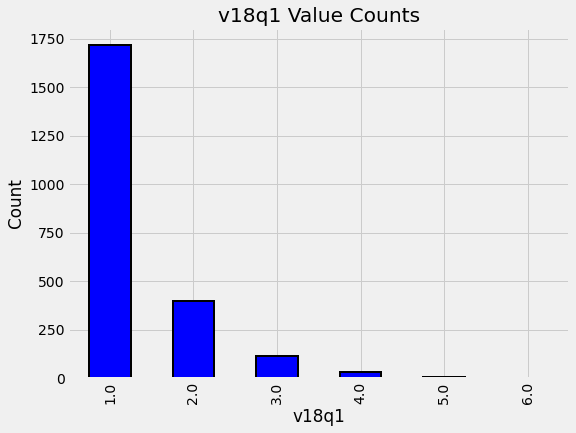

In [21]:
plot_value_counts(heads, 'v18q1')

태블릿 수는 1개

In [22]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

In [23]:
data['v18q1'] = data['v18q1'].fillna(0)

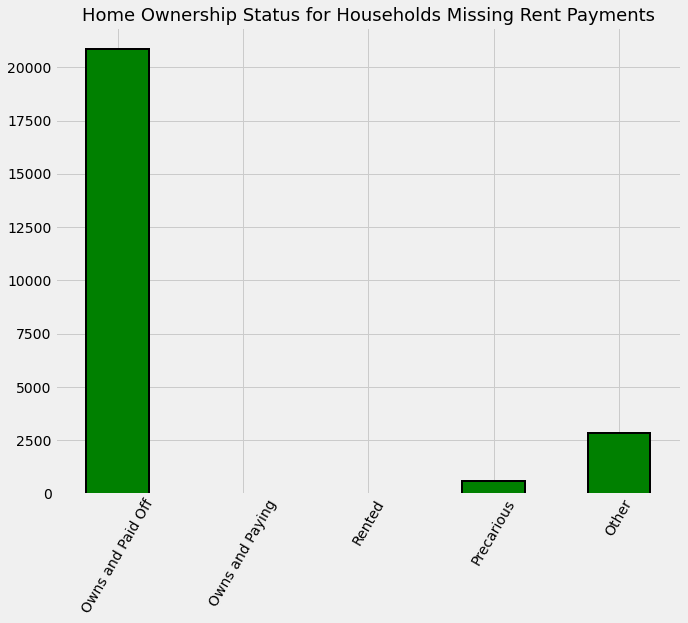

In [24]:
own_variables = [x for x in data if x.startswith('tipo')]


data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

In [25]:
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

In [26]:
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

In [28]:
# 만약 개인이 19이상, 7살 이하이면 0으로
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

In [29]:
def plot_categoricals(x, y, data, annotate = True):

    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

C:\Users\pjy97\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


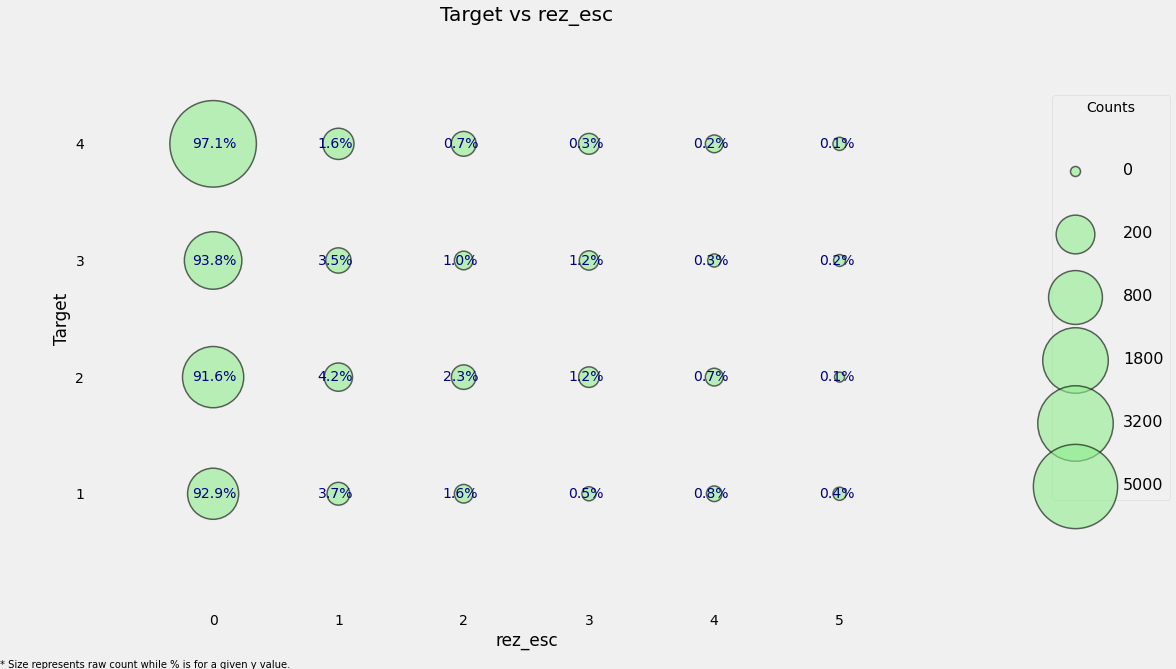

In [30]:
plot_categoricals('rez_esc', 'Target', data);

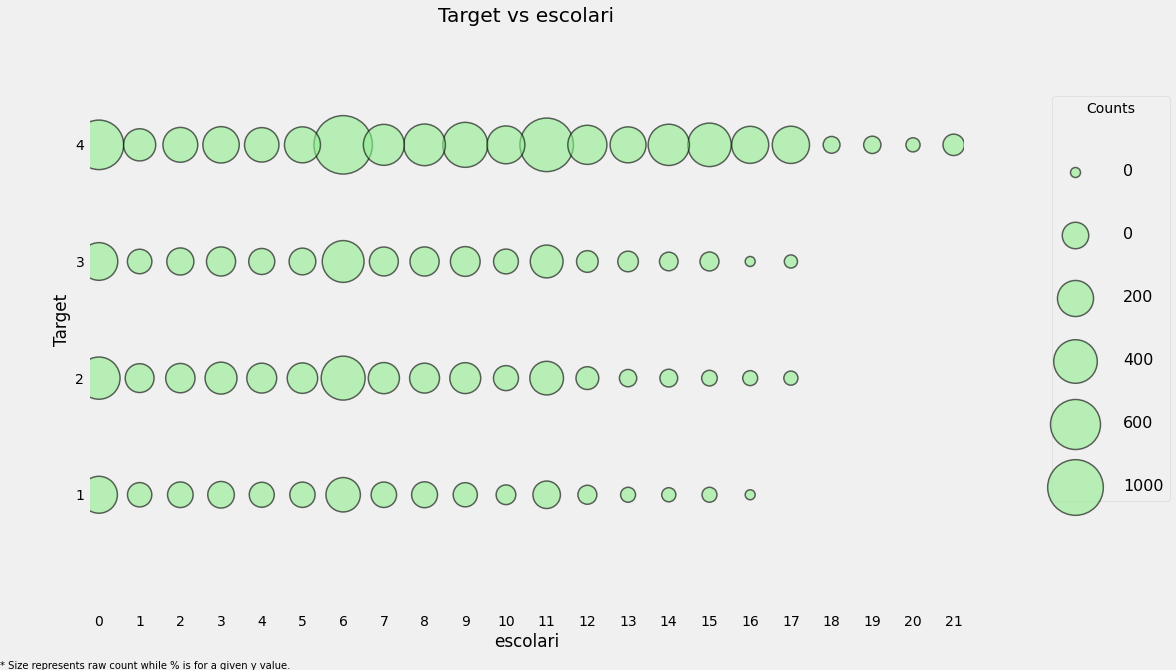

In [31]:
plot_categoricals('escolari', 'Target', data, annotate = False)

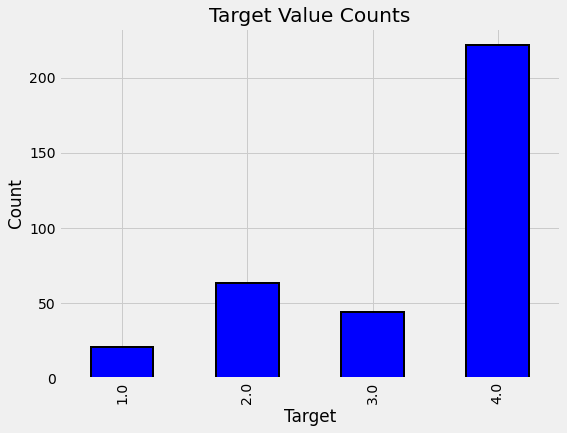

In [32]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 
                  'Target')

# feature engeneering
1. house hold와 개인 수준으로 변수 분리
2. 개인 수준에서 적절한 agg를 찾는다.
3. 개인의 agg를 house hold level 수준으로 합친다.

In [33]:
id_ = ['Id', 'idhogar', 'Target']
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [34]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

There are no repeats:  True
We covered every variable:  True


### 제곱 변수 제거: 선형 모형이 비선형관계를 학습쓰려고 만듦

제곱 변수와 일반 변수의 상관관계가 높아서

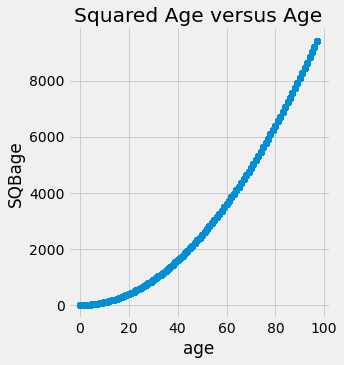

In [35]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

In [36]:
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

In [37]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

In [38]:
# 상관관계 높은거 제거
corr_matrix = heads.corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [39]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


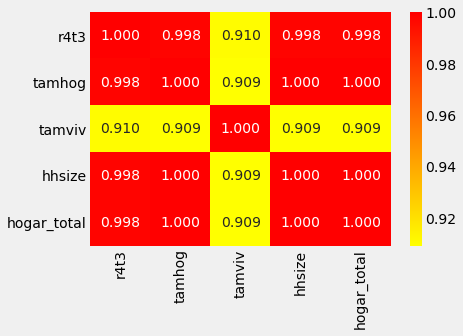

In [40]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

In [41]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

C:\Users\pjy97\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


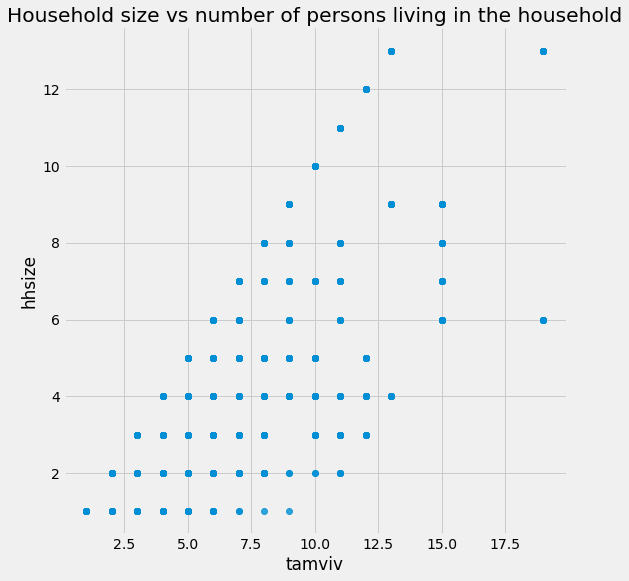

In [42]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

C:\Users\pjy97\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


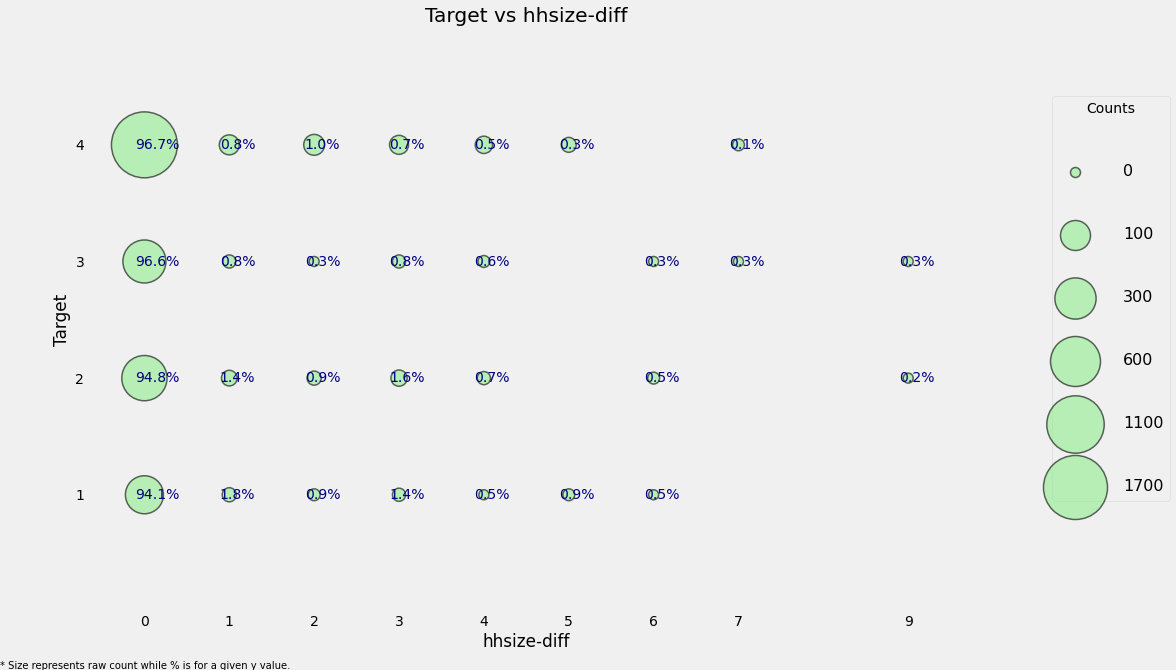

In [43]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

In [45]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

전기 열을 삭제하고 새로운 데이터를 만듦

C:\Users\pjy97\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


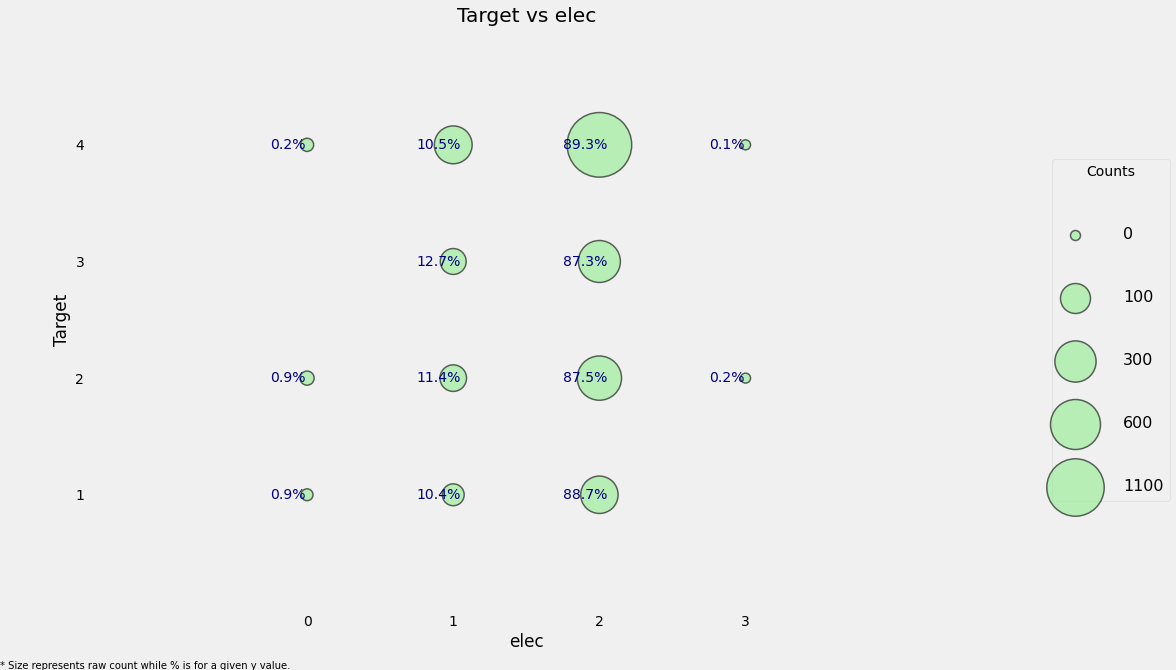

In [46]:
plot_categoricals('elec', 'Target', heads)


In [47]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

도시와 시골간의 부의 차이가 있다.

C:\Users\pjy97\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


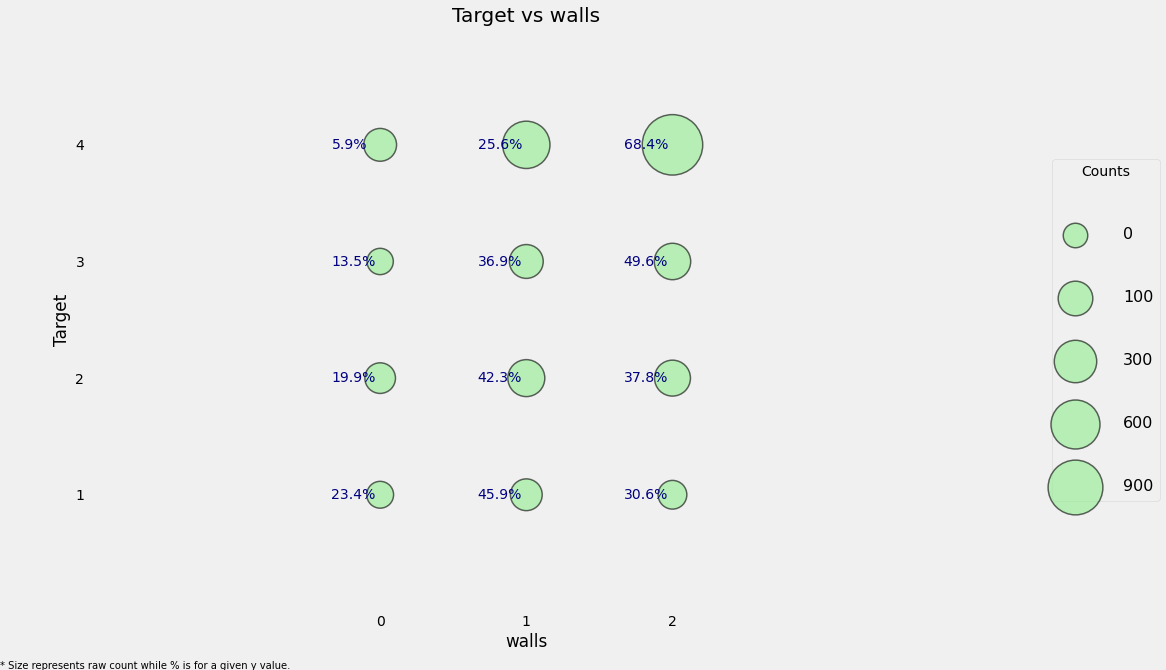

In [48]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
plot_categoricals('walls', 'Target', heads)

In [49]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

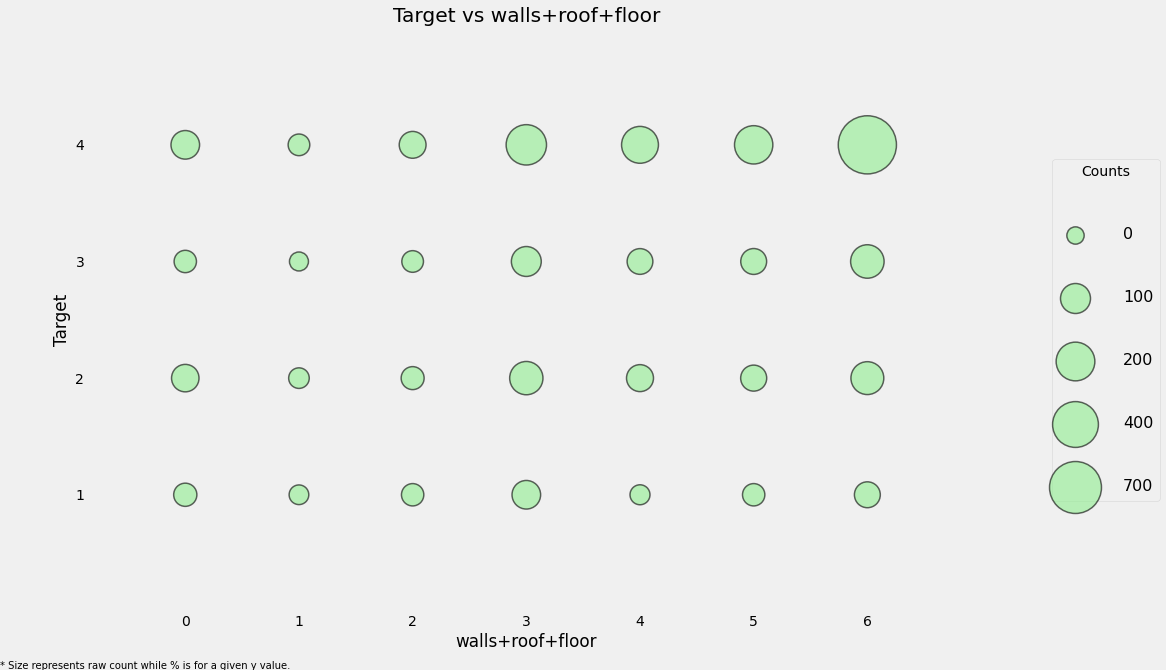

In [50]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

In [51]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


In [52]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

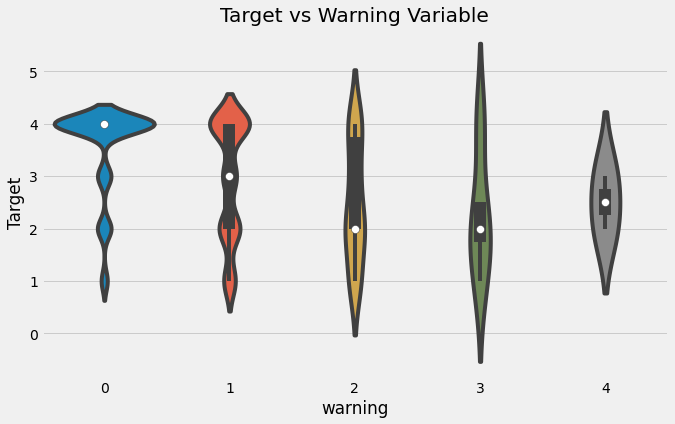

In [53]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'warning', y = 'Target', data = heads);
plt.title('Target vs Warning Variable');

C:\Users\pjy97\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


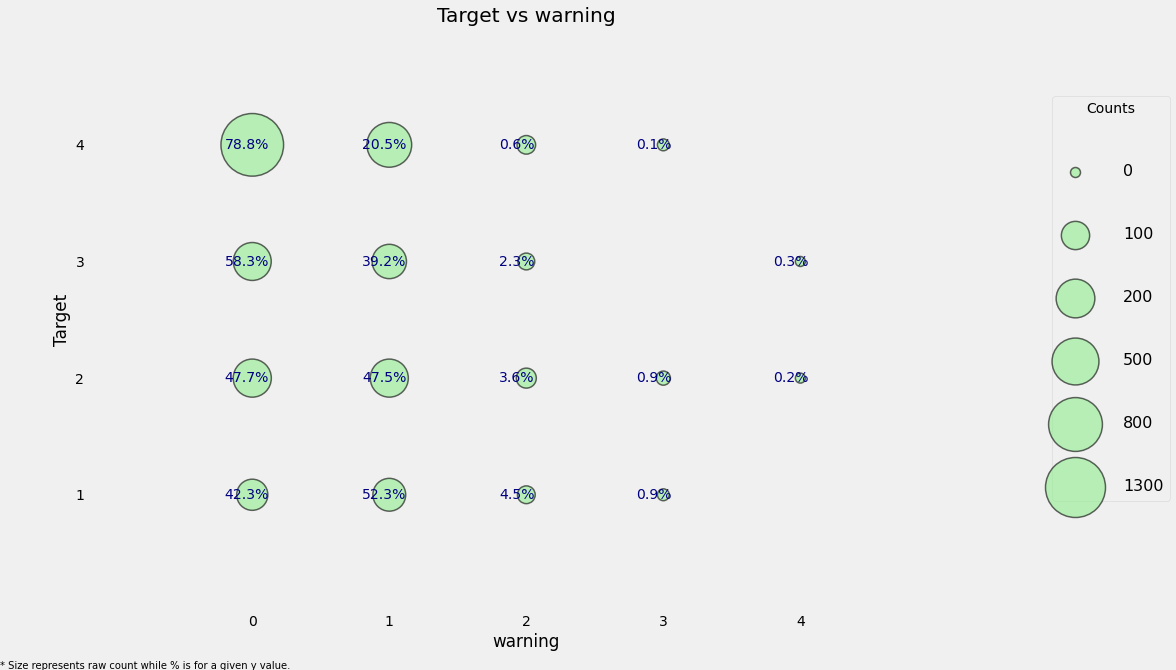

In [54]:
plot_categoricals('warning', 'Target', data = heads)

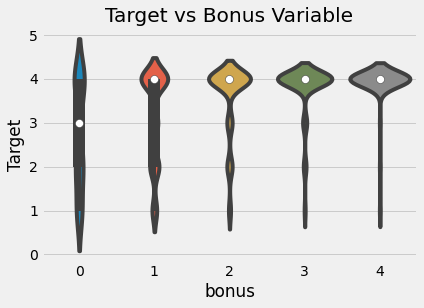

In [55]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Bonus Variable');

In [56]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## household 변수 조사
- 관계 측청
    1. pearson correlation : -1~1 선형관계 확인 (한변수가 증가하면 다른변수가 선형관계가 아니더라도 증가)
    2. spearman correlation : -1~1 monotonic 관계 확인(증가량이 확실히 선형인경우)

In [57]:
from scipy.stats import spearmanr


In [58]:
def plot_corrs(x, y):
    """Plot data and show the spearman and pearson correlation."""
    
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]
    
    data = pd.DataFrame({'x': x, 'y': y})
    plt.figure( figsize = (6, 4))
    sns.regplot('x', 'y', data = data, fit_reg = False);
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');

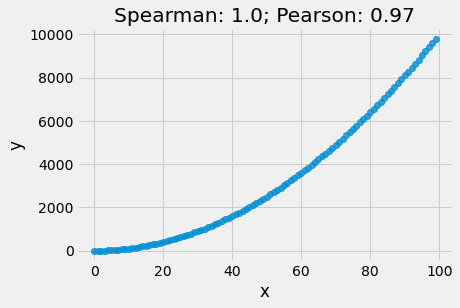

In [59]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x, y)

spear man 상관관계는 target or 년도와 같은 ordinal variable에 사용하기 적합.<br>
두 변수의 연관성에 대한 근사치일 수 있지만 정확하지 않고 최고의 방법은 아니다.

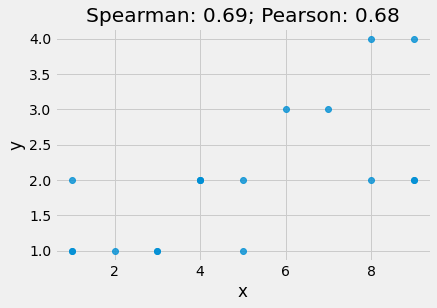

In [60]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corrs(x, y)

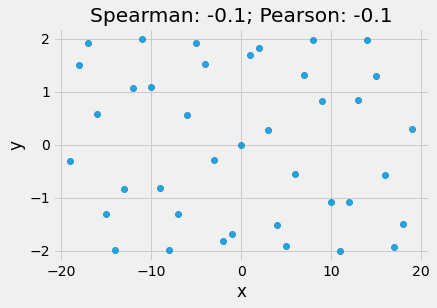

In [61]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

plot_corrs(x, y)

In [62]:
# Use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

Most positively correlated variables:
               feature     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


### spearman 선형관계

In [63]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

spearman의 상관관계 계산에는 p-value도 제공된다.<br>
0.05보다 작은 p-value는 일반적으로 유의하지만, 다중분류이기 때문에 p-value를 class수로 나눈다.(Bonferroni 보정) 

In [64]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
       feature     scorr        pvalue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33

Most positive Spearman correlations:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


In [65]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
77,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
85,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
87,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
97,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [66]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
57,techozinc,0.014357,0.003404,8.528369e-01,0.010954
49,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
88,edjefe,0.235687,0.214736,2.367521e-32,0.020951
66,edjefa,0.052310,0.005114,7.804715e-01,0.047197
17,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


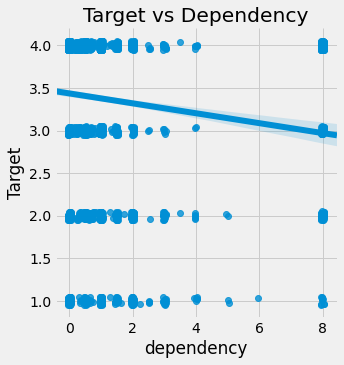

In [67]:
sns.lmplot('dependency', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Dependency');

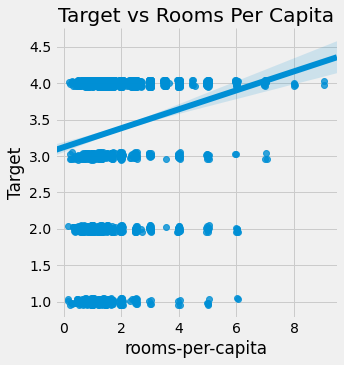

In [68]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

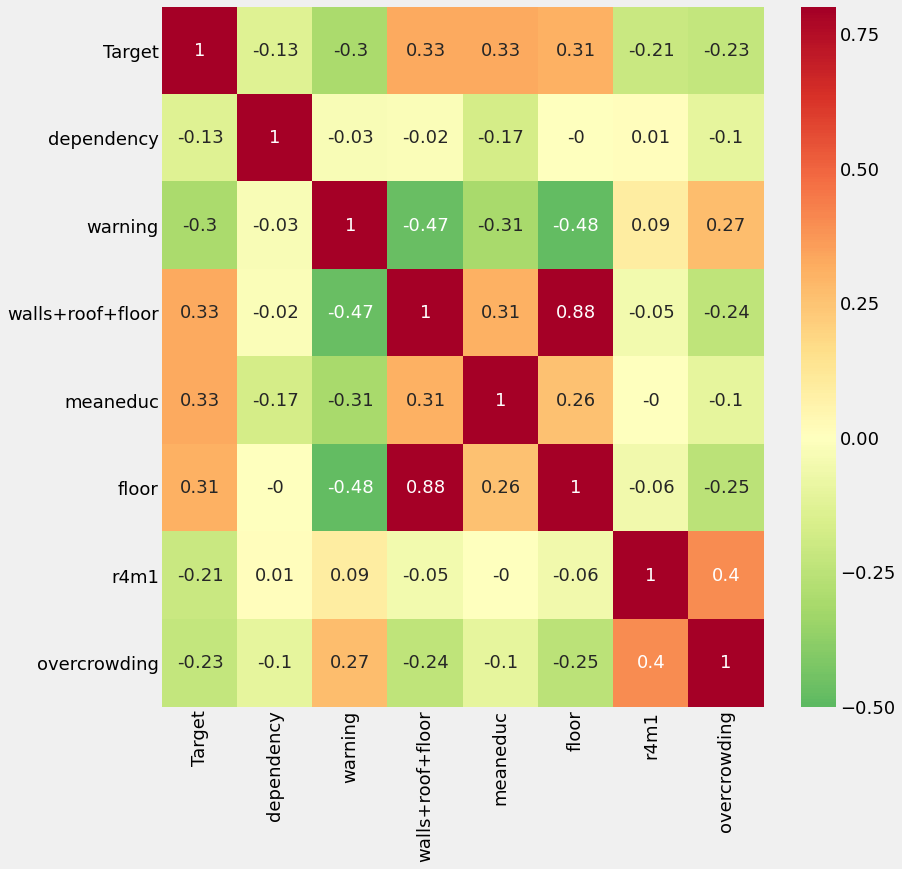

In [69]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

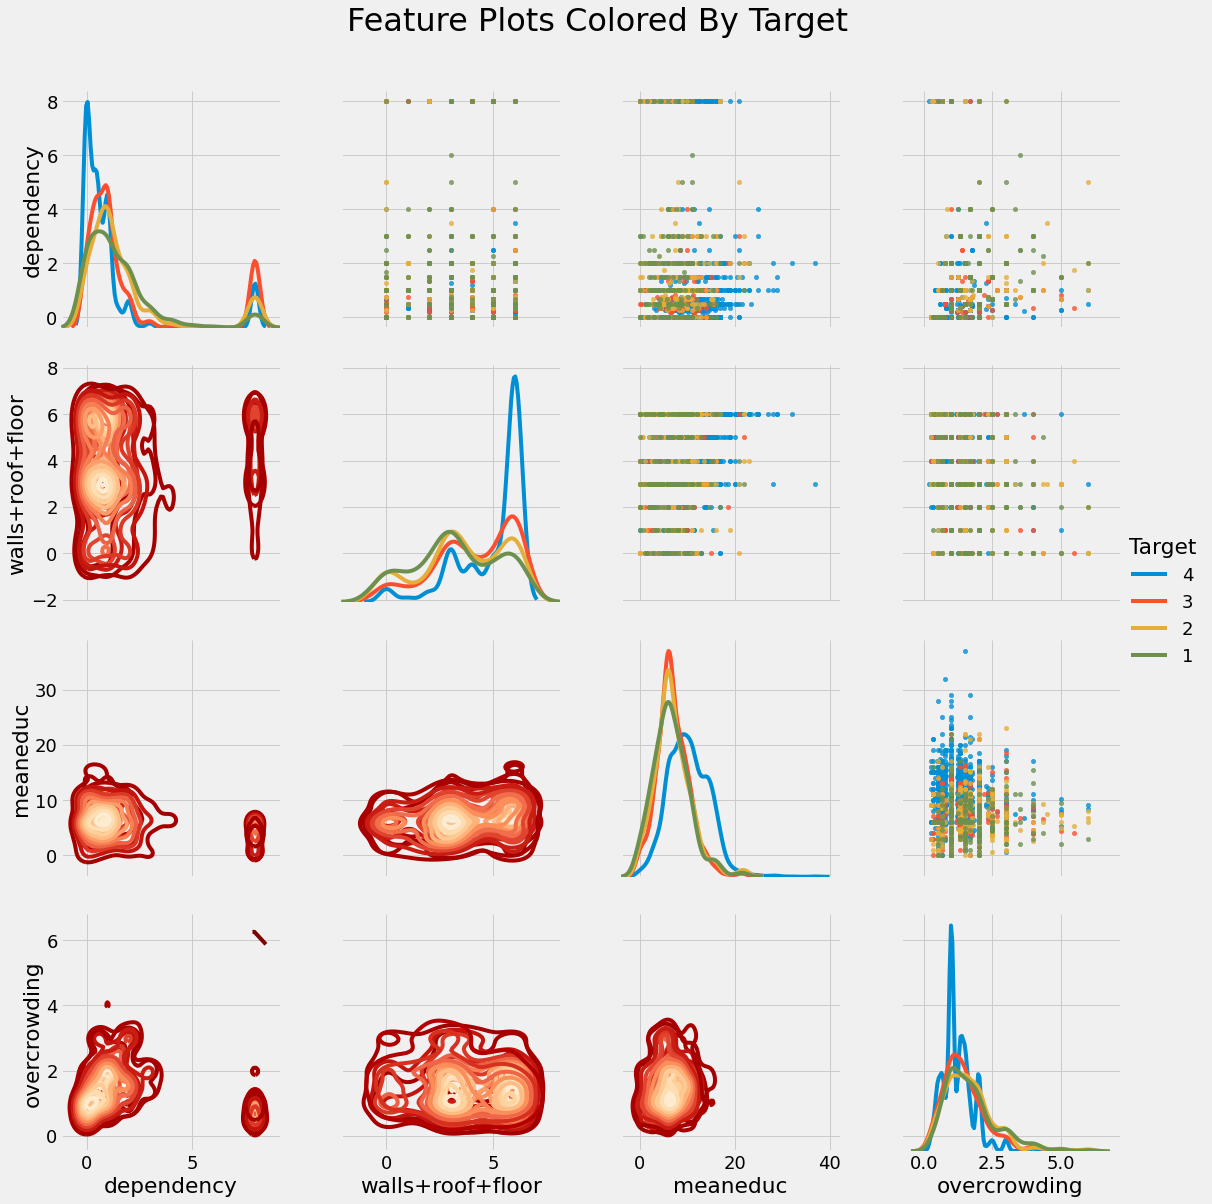

In [70]:
import warnings
warnings.filterwarnings('ignore')

plot_data = train_heads[['Target', 'dependency', 'walls+roof+floor',
                         'meaneduc', 'overcrowding']]

grid = sns.PairGrid(data = plot_data, size = 4, diag_sharey=False,
                    hue = 'Target', hue_order = [4, 3, 2, 1], 
                    vars = [x for x in list(plot_data.columns) if x != 'Target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.8, s = 20)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size = 32, y = 1.05);

In [71]:
household_feats = list(heads.columns)

In [72]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

In [73]:
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

In [74]:
ind = ind.drop(columns = 'male')

In [75]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


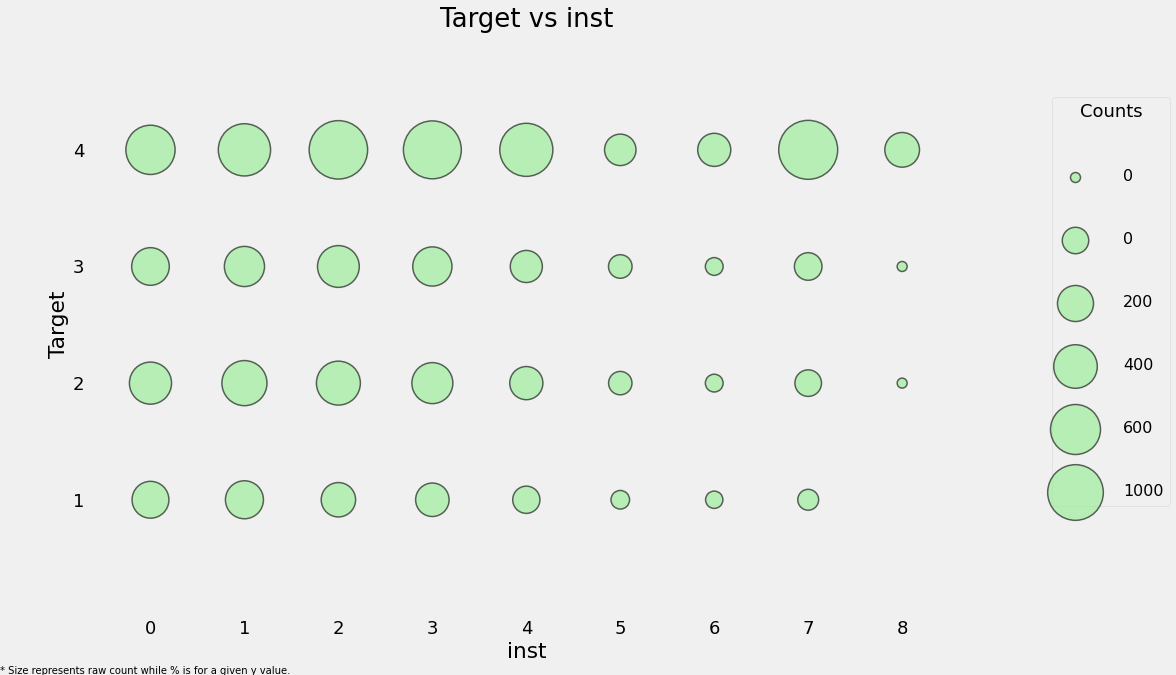

In [76]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

plot_categoricals('inst', 'Target', ind, annotate = False);

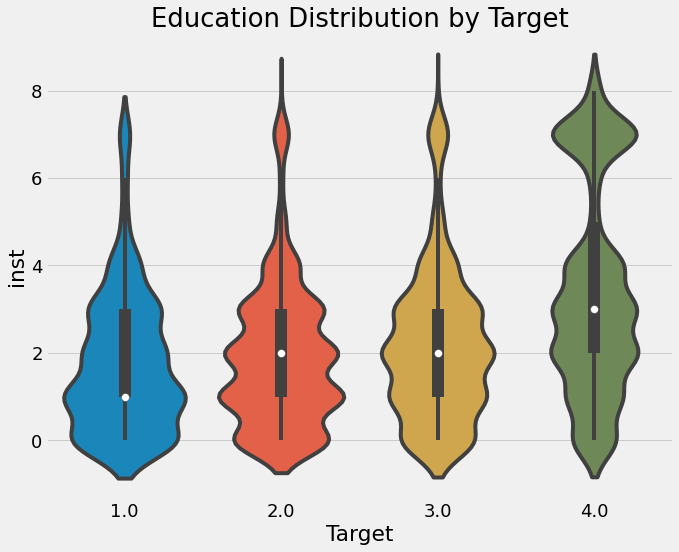

In [77]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

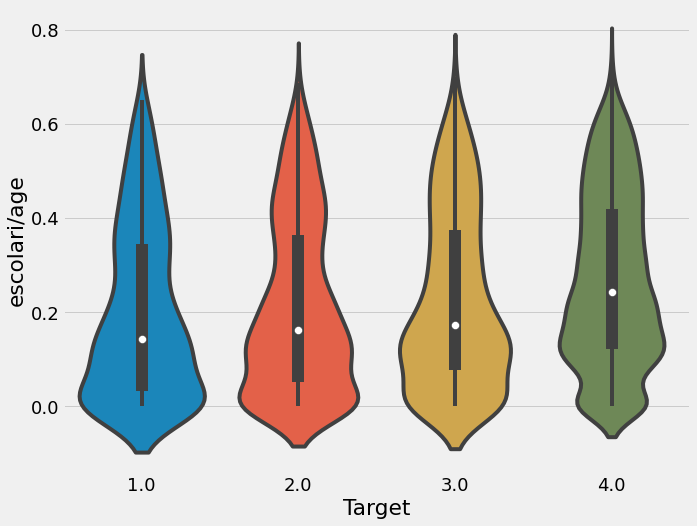

In [78]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

In [79]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

In [80]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

In [81]:
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,estadocivil4-std,estadocivil4-range_,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil5-count,estadocivil5-std,estadocivil5-range_,estadocivil6-min,estadocivil6-max,estadocivil6-sum,estadocivil6-count,estadocivil6-std,estadocivil6-range_,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-count,estadocivil7-std,estadocivil7-range_,parentesco1-min,parentesco1-max,parentesco1-sum,parentesco1-count,parentesco1-std,parentesco1-range_,parentesco2-min,parentesco2-max,parentesco2-sum,parentesco2-count,parentesco2-std,parentesco2-range_,parentesco3-min,parentesco3-max,parentesco3-sum,...,instlevel5-count,instlevel5-std,instlevel5-range_,instlevel6-min,instlevel6-max,instlevel6-sum,instlevel6-count,instlevel6-std,instlevel6-range_,instlevel7-min,instlevel7-max,instlevel7-sum,instlevel7-count,instlevel7-std,instlevel7-range_,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-count,instlevel8-std,instlevel8-range_,instlevel9-min,instlevel9-max,instlevel9-sum,instlevel9-count,instlevel9-std,instlevel9-range_,mobilephone-min,mobilephone-max,mobilephone-sum,mobilephone-count,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,1,2,3,0.577350,1,0,0,0,3,0.0,0,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.5,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,1,1,4,0.500000,1,0,0,0,4,0.0,0,1,1,4,4,0.0,0,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2,0.707107,1,0,0,0,2,0.00

In [82]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()


,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


In [83]:
corr_matrix = ind_agg.corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 111 correlated columns to remove.


In [84]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 228)


In [85]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,...,parentesco6-max,parentesco6-sum,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,instlevel1-min,instlevel1-max,instlevel1-sum,instlevel2-min,instlevel2-max,instlevel2-sum,instlevel2-std,instlevel3-min,instlevel3-max,instlevel3-sum,instlevel3-std,instlevel4-min,instlevel4-max,instlevel4-sum,instlevel4-std,instlevel5-min,instlevel5-max,instlevel5-sum,instlevel6-min,instlevel6-max,instlevel7-min,instlevel7-max,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-std,instlevel9-min,instlevel9-max,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,NaN,0,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,1,1,NaN,0,0,1,NaN,0,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,2,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,1,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


In [86]:
corrs = final.corr()['Target']


In [87]:
corrs.sort_values().head()


warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [88]:
corrs.sort_values().dropna().tail()


walls+roof+floor    0.332446
meaneduc            0.333652
inst-max            0.368229
escolari-max        0.373091
Target              1.000000
Name: Target, dtype: float64

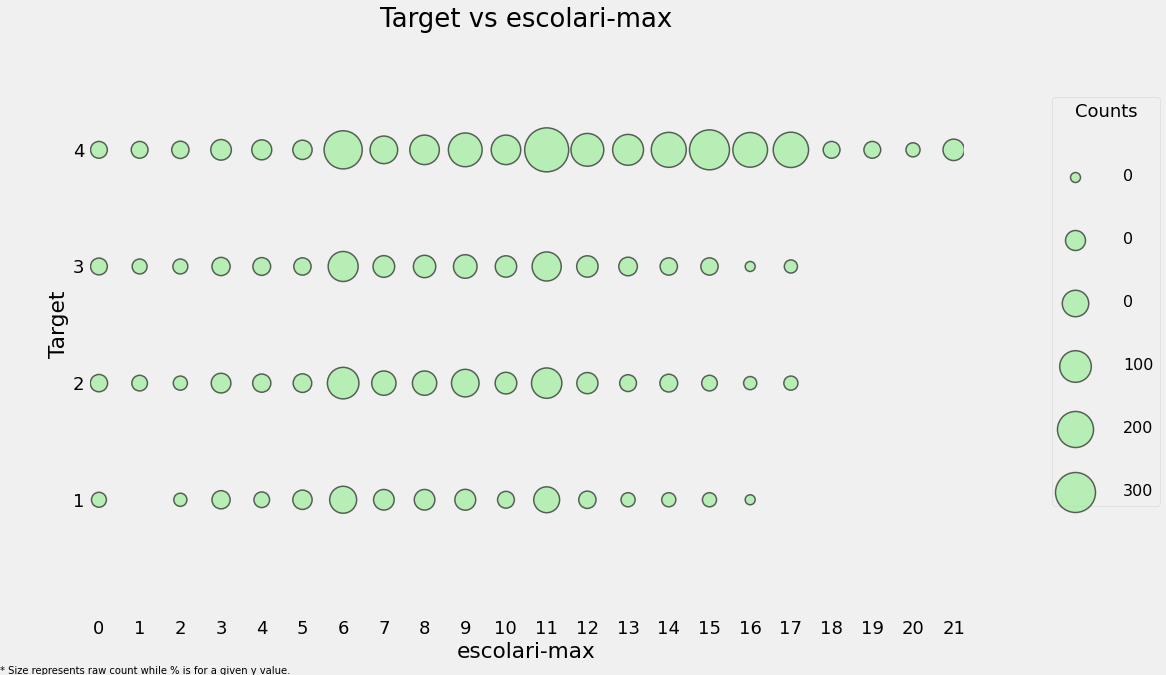

In [89]:
plot_categoricals('escolari-max', 'Target', final, annotate=False);

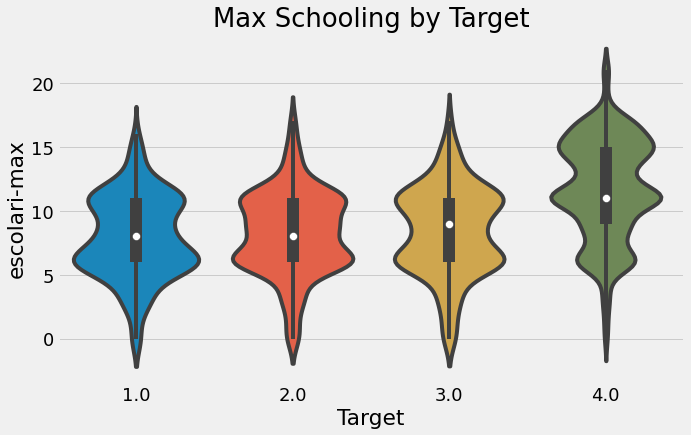

In [90]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

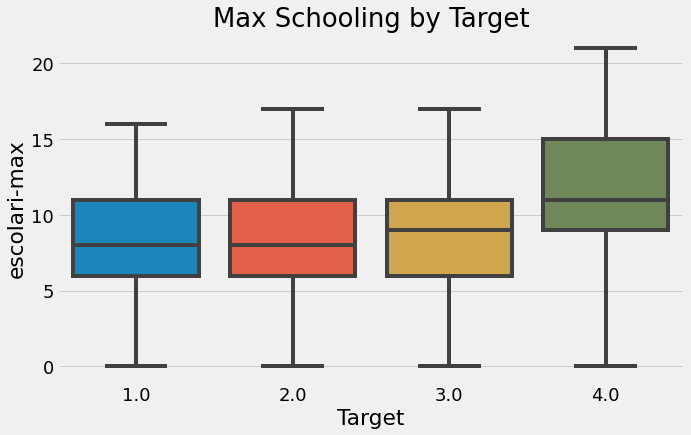

In [91]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

In [93]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [94]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

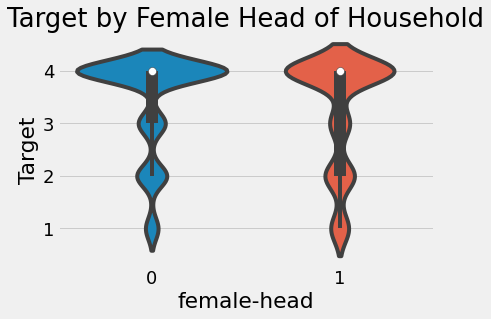

In [95]:
sns.violinplot(x = 'female-head', y = 'Target', data = final);
plt.title('Target by Female Head of Household');

# modeling

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [98]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

In [99]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

In [100]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3439 with std = 0.0438


In [101]:
model.fit(train_set, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000643
1,hacapo,0.000283
2,v14a,0.000460
3,refrig,0.001798
4,paredblolad,0.006024


In [102]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

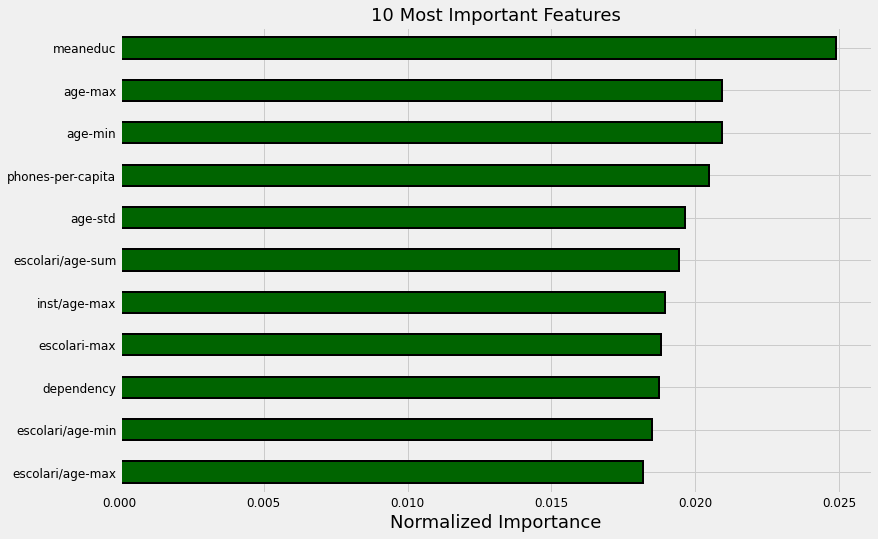

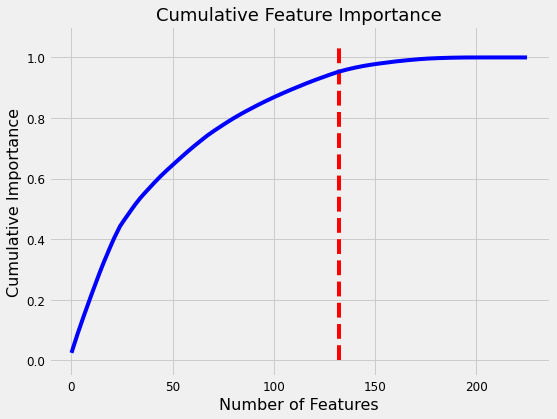

132 features required for 95% of cumulative importance.


In [103]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

In [104]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

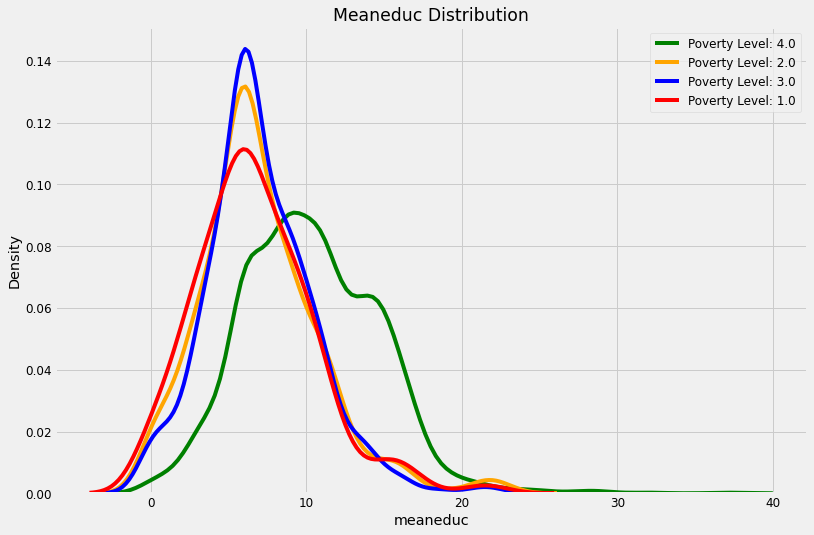

In [105]:
kde_target(final, 'meaneduc')


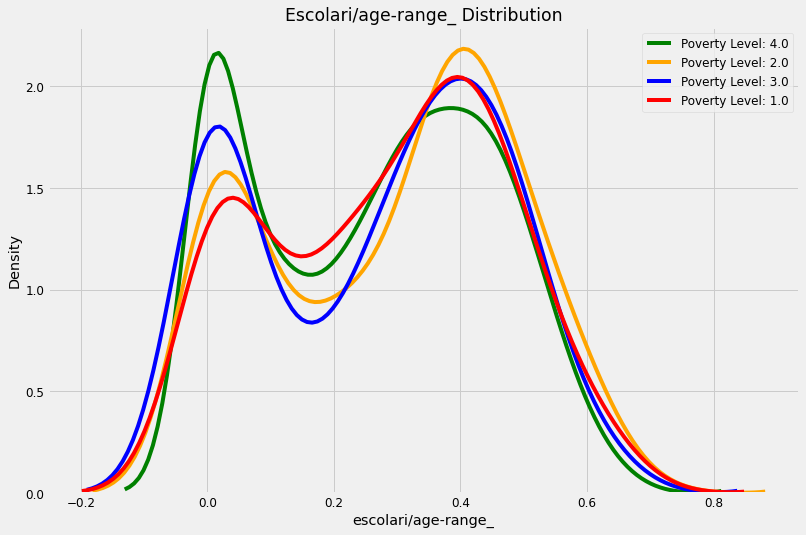

In [106]:
kde_target(final, 'escolari/age-range_')


In [107]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [108]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [109]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.28552 with std: 0.03985


In [110]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.18451 with std: 0.03657


In [113]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.31588 with std: 0.0513


In [114]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.31792 with std: 0.06199


In [115]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27803 with std: 0.0342


In [111]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.34765 with std: 0.03354

KNN with 10 neighbors

10 Fold CV Score: 0.31992 with std: 0.03213

KNN with 20 neighbors

10 Fold CV Score: 0.30723 with std: 0.04762


In [112]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.32681 with std: 0.05096


In [116]:
model_results = cv_model(train_set, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.34394 with std: 0.04381


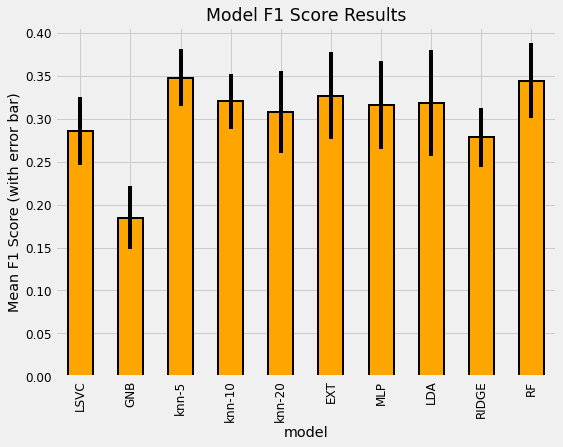

In [117]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

In [118]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [119]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

In [120]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100, 
                                              random_state=10, n_jobs = -1), 
                         train_set, train_labels, test_set, test_ids)

rf_submission.to_csv('rf_submission.csv', index = False)

# feature selection

- 상관관계 높은거 제거
- RFECV - 교차 검증을 통해 재귀 변수 제거

In [130]:
train_set = pd.DataFrame(train_set, columns = features)

# Create correlation matrix
corr_matrix = train_set.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'elec', 'v18q-count', 'female-sum']

In [131]:
train_set = train_set.drop(columns = to_drop)
train_set.shape

(2973, 222)

In [132]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

In [133]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

# Create the object
selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

In [134]:
selector.fit(train_set, train_labels)

RFECV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=10),
      n_jobs=-1, scoring=make_scorer(f1_score, average=macro))

169

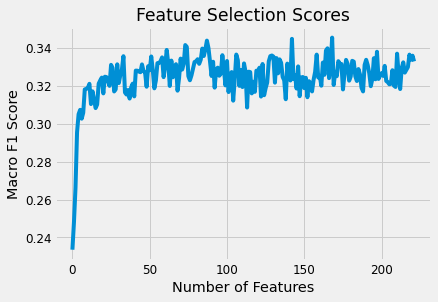

In [135]:
plt.plot(selector.grid_scores_);

plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
selector.n_features_

In [136]:
train_set

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,...,parentesco6-sum,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,instlevel1-min,instlevel1-max,instlevel1-sum,instlevel2-min,instlevel2-max,instlevel2-sum,instlevel2-std,instlevel3-min,instlevel3-max,instlevel3-sum,instlevel3-std,instlevel4-min,instlevel4-max,instlevel4-sum,instlevel4-std,instlevel5-min,instlevel5-max,instlevel5-sum,instlevel6-min,instlevel6-max,instlevel7-min,instlevel7-max,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-std,instlevel9-min,instlevel9-max,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_,female-head
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.080732,0.000000,0.476190,0.000000,0.270270,0.137931,0.2,0.0,0.125,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,1.0,0.2,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.476190,0.476190,0.086207,0.233285,0.000000,0.457447,0.316456,0.070423,0.385782,0.000000,0.375,0.250000,0.000,0.332226,0.314637,0.042686,0.373198,0.000000,0.179402,0.285291,0.000000,0.5,0.045455,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.057362,1.000000,0.571429,0.000000,0.324324,0.137931,0.3,0.0,0.125,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.571429,0.571429,0.103448,0.233285,0.000000,0.712766,0.620253,0.138028,0.385782,0.000000,0.875,0.250000,0.000,0.255864,0.242318,0.032875,0.373198,0.000000,0.268657,0.285291,0.000000,1.0,0.090909,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.000000,0.523810,0.297297,0.051724,0.7,0.0,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,1.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.523810,0.523810,0.094828,0.233285,0.000000,0.978723,0.936709,0.208451,0.385782,0.000000,0.500,0.250000,0.000,0.

In [137]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

,feature,rank
110,female-range_,1
124,estadocivil5-sum,1
125,estadocivil6-min,1
126,estadocivil6-max,1
127,estadocivil7-min,1
128,estadocivil7-max,1
129,estadocivil7-sum,1
130,estadocivil7-std,1
133,parentesco1-std,1
135,parentesco2-max,1


In [138]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [139]:
# Convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [140]:
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10 Fold CV Score: 0.35016 with std: 0.04098


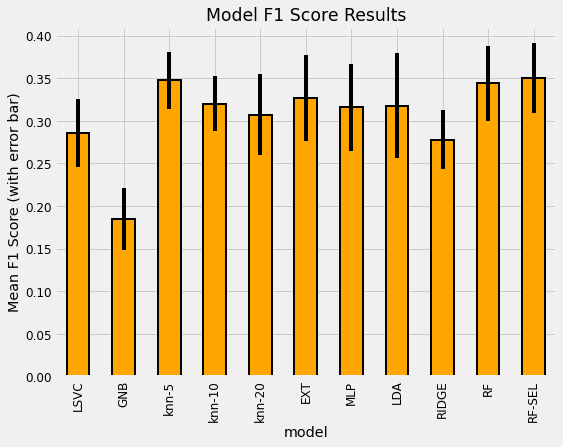

In [141]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                 edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

In [142]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [143]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

In [144]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_set, train_labels, test_set, test_ids, return_preds=True)

'Fold 1, Validation Score: 0.37331, Estimators Trained: 0'

'Fold 2, Validation Score: 0.39693, Estimators Trained: 0'

'Fold 3, Validation Score: 0.36429, Estimators Trained: 0'

'Fold 4, Validation Score: 0.42366, Estimators Trained: 0'

'Fold 5, Validation Score: 0.42455, Estimators Trained: 0'

'5 cross validation score: 0.39655 with std: 0.0249.'

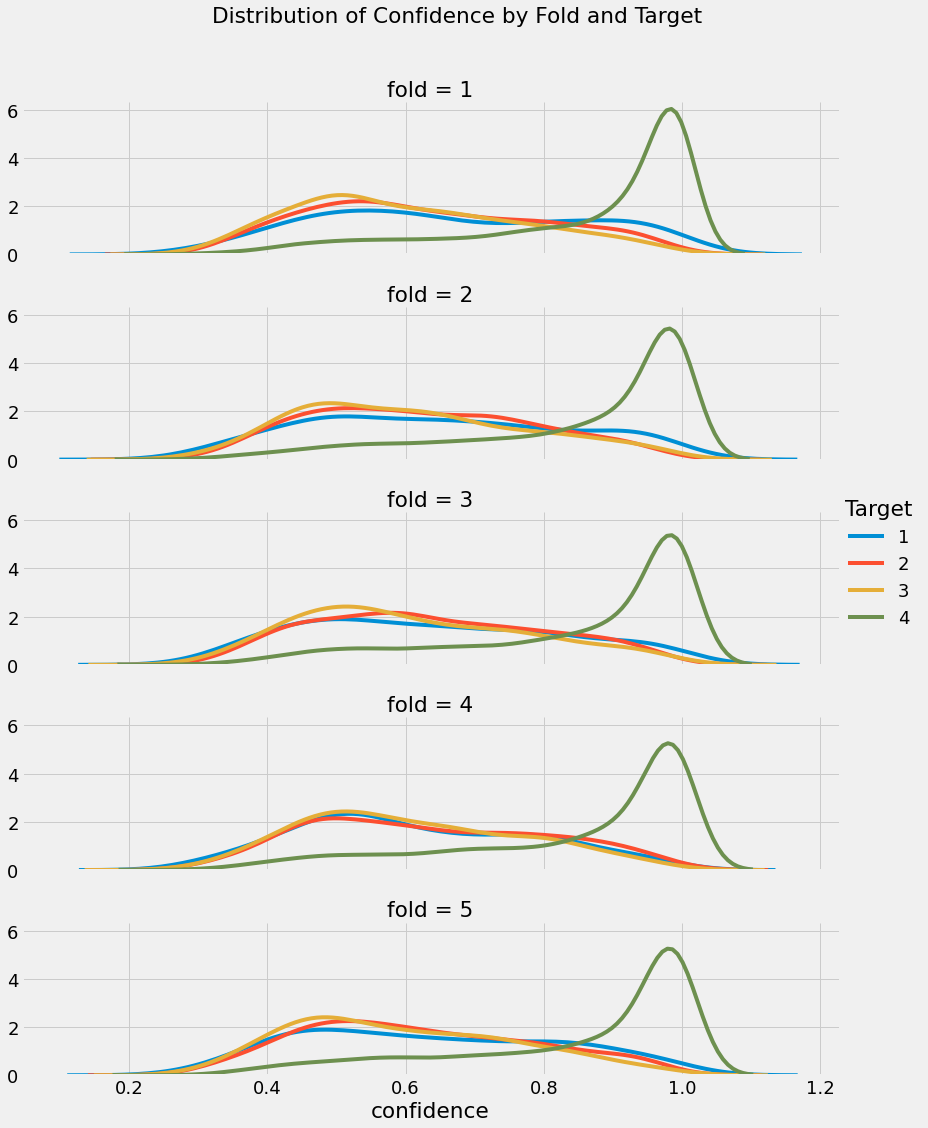

In [145]:
plt.rcParams['font.size'] = 18

# Kdeplot
g = sns.FacetGrid(predictions, row = 'fold', hue = 'Target', size = 3, aspect = 4)
g.map(sns.kdeplot, 'confidence');
g.add_legend();

plt.suptitle('Distribution of Confidence by Fold and Target', y = 1.05);